In [1]:
# @title
### EP3 MAC0417 / MAC5768 ##################################################
#  AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP,              #
#  DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELAS RESPOSTAS NESTA LISTA.    #
#  TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM, SEGUINDO AS    #
#  INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM DESONESTIDADE ACADÊMICA OU PLÁGIO.#
#                                                                              #
#  DECLARO TAMBÉM QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS                      #
#  DESSE PROGRAMA E QUE EU NÃO DISTRIBUI OU FACILITEI A                        #
#  SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E                     #
#  DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS                 #
#  DEFINIDOS NO CÓDIGO DE ÉTICA DA USP.                                        #
#  ENTENDO QUE LISTAS SEM ASSINATURA NÃO SERÃO CORRIGIDAS E,                   #
#  AINDA ASSIM, PODERÃO SER PUNIDOS POR DESONESTIDADE ACADÊMICA.               #
#                                                                              #
#  Nome : Érico Tiago Meireles                                                 #
#  NUSP : 9312428                                                              #
#  Turma: MAC5768 Visão e Processamento de Imagens                             #
#  Prof.: Ronaldo Fumio Hashimoto                                              #
################################################################################

## EP3 - Parte 3 -  Treinamento do modelo e classificação do objeto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import cv2

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

In [2]:
random_seed = 100 

#### Importa os dados das imagens avaliadas:

In [3]:
df = pd.read_excel('..\image_characteristics.xlsx')

Manualmente os objetos do arquivo acima foram classificados com auxílio das imagens do diretório contours, gerada no código da parte 2. Ao avaliar essas imagens com os contornos desenhados separadamente, pode-se classificar cada contorno conforme o objeto correspondente.


In [4]:
df.columns

Index(['img', 'path_origin', 'Objeto', 'n_contorno', 'Área', 'Diâmetro',
       'Minor', 'Centroide_X', 'Centroide_Y', 'Classe', 'n_objetos'],
      dtype='object')

In [5]:
## Remove colunas desnecessárias para o treinamento, que foram utinilzadas apenas para classificação manual dos objetos
df.drop(columns=['Centroide_X', 'Centroide_Y'],inplace=True)

Importante ressaltar que manualmente foi classificado alguns contornos como "errados", geralmente backgrounds que tinham sido selecionados como contornos. Também importante comentar que NENHUMA imagem segmentada retornou todos os objetos, os contornos sempre apareciam 2 ou até 3 vezes no mesmo objeto, dessa forma, uma mesma imagem gerou diferentes linhas para o mesmo objeto.

In [6]:
df.groupby('Objeto')['img'].count()

Objeto
caneca            105
caneta            118
capacete           53
colher            112
erro               22
faca               99
garfo              68
livro             119
pilha              38
protetor solar    151
som                87
Name: img, dtype: int64

In [7]:
df = df[df['Objeto'] != 'erro']

É possível ver os valores errados que serão excluídos do dataframe para o treinamento

In [8]:
df.groupby('Objeto')['img'].count()

Objeto
caneca            105
caneta            118
capacete           53
colher            112
faca               99
garfo              68
livro             119
pilha              38
protetor solar    151
som                87
Name: img, dtype: int64

Vemos que os 10 objetos são desbalanceados na nossa base, o que mostra que a detecção de portas funcionou melhor para alguns objetos do que outros, exemplo protetor solar com mais de 150 ocorrências, enquanto a pilha teve menos de 40.

### Treinamento de um modelo inicial para avaliação:

In [35]:
# Separar as features e a target
X = df[['n_contorno', 'Área', 'Diâmetro', 'Minor']]
y = df['Objeto']

In [36]:
# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = random_seed)

In [45]:
# Criar o modelo Random Forest
rf_model = RandomForestClassifier( max_depth = 100, min_samples_leaf = 2, n_estimators = 100, random_state = random_seed)

In [46]:
# Treinar o modelo
rf_model.fit(X_train.iloc[:, :-1], y_train)

RandomForestClassifier(max_depth=100, min_samples_leaf=2, random_state=100)

In [47]:
# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test.iloc[:, :-1])

# Fazer previsões no conjunto de teste
y_pred_train = rf_model.predict(X_train.iloc[:, :-1])

## Avaliar o modelo

#### Performance do modelo no Conjunto de treino

In [ ]:

accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)
conf_matrix = confusion_matrix(y_train, y_pred_train, labels=df['Objeto'].unique())

print(f'Acurácia: {accuracy}')
print('Parâmetros por objeto:')
print(report)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True,  cmap='Blues', 
            xticklabels=df['Objeto'].unique(), yticklabels=df['Objeto'].unique())
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

#### Performance do modelo no Conjunto de teste

Acurácia: 0.42657342657342656
Relatório de Classificação:
                precision    recall  f1-score   support

        caneca       0.40      0.29      0.33        14
        caneta       0.50      0.62      0.56        16
      capacete       0.29      0.25      0.27         8
        colher       0.40      0.38      0.39        16
          faca       0.29      0.67      0.40         9
         garfo       0.45      0.38      0.42        13
         livro       0.36      0.62      0.46        13
         pilha       0.00      0.00      0.00         8
protetor solar       0.50      0.50      0.50        24
           som       0.67      0.36      0.47        22

      accuracy                           0.43       143
     macro avg       0.39      0.41      0.38       143
  weighted avg       0.43      0.43      0.41       143



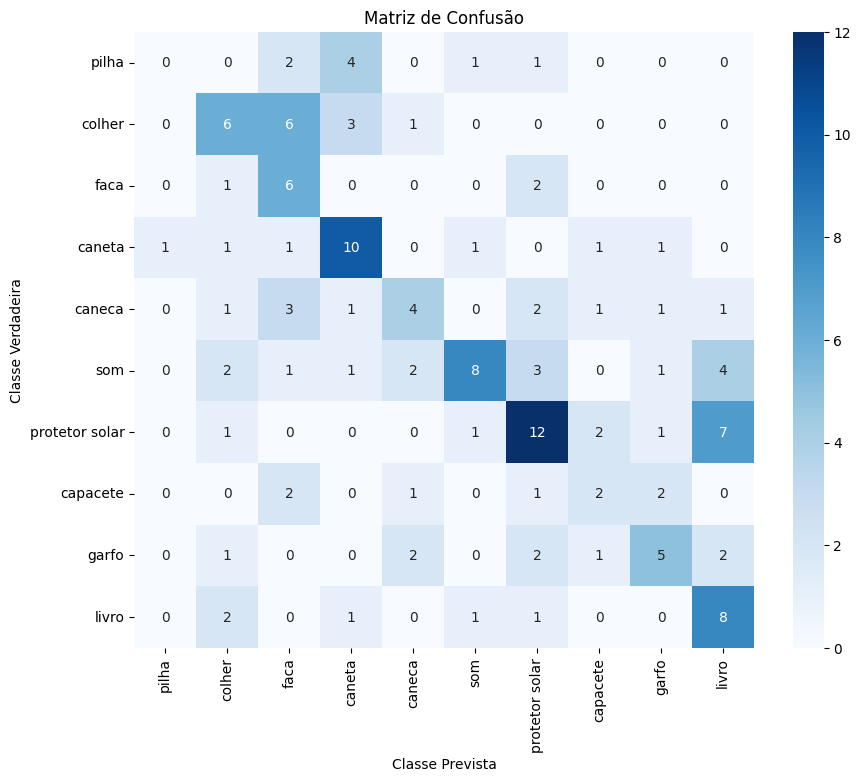

In [48]:

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=df['Objeto'].unique())

print(f'Acurácia: {accuracy}')
print('Parâmetros por objeto:')
print(report)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True,  cmap='Blues', 
            xticklabels=df['Objeto'].unique(), yticklabels=df['Objeto'].unique())
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

### Definição dos melhores hiperparâmetros:

In [90]:
# Definir os hiperparâmetros para testar
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
     'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': list(range(50))
}

# Criar o classificador Random Forest
clf = RandomForestClassifier()

# Criar o GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Treinar o GridSearchCV
grid_search.fit(X_train, y_train)

# Obter o melhor classificador
best_clf = grid_search.best_estimator_

# Prever os resultados para o conjunto de teste usando o melhor classificador
y_pred_train = best_clf.predict(X_train)
y_pred = best_clf.predict(X_test)


# Calcular a acurácia
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred)


# Obter os resultados do grid search
results = grid_search.cv_results_

# Obter os scores de teste para cada combinação de hiperparâmetros
score_means = results['mean_test_score']

score_stds = results['std_test_score']
param_values = [str(x) for x in grid_search.cv_results_['params']]

print(f"Melhor conjunto de hiperparâmetros: {grid_search.best_params_}")
print(f"Acurácia com o melhor classificador: {accuracy:.2f}")

In [88]:
best_clf

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=2)

In [77]:
best_clf

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=63)

### Variação do valor do random_state:

In [ ]:
acuracias = []
for i in range(0, 300):  # Repetir 100 vezes, altere conforme necessário
    # Dividir os dados em treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=i)

    # Criar o classificador Random Forest
    clf = RandomForestClassifier(random_state=i, max_depth = 100, min_samples_leaf = None, n_estimators = 100)

    # Treinar o modelo
    clf.fit(X_train, y_train)

    # Prever os resultados para o conjunto de teste
    y_pred = clf.predict(X_test)

    # Calcular a acurácia e adicionar à lista
    acuracias.append(accuracy_score(y_test, y_pred))

# Calcular a acurácia média
acuracia_media = np.mean(acuracias)

# Calcular a melhor acurácia e qual o random state
for i in range(len(acuracias)):
    if acuracias[i] == np.max(acuracias):
        print(f'Iteração {i}: Melhor acurácia ({round(acuracias[i]*100, 2)}%)')
        melhor_random_state = i

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=melhor_random_state)

best_clf = RandomForestClassifier(random_state=melhor_random_state, max_depth = 100, min_samples_leaf = None, n_estimators = 100)

# Treinar o modelo
best_clf.fit(X_train, y_train)

# Prever os resultados para o conjunto de teste
y_pred = best_clf.predict(X_test)

# Prever os resultados para o conjunto de teste
y_pred_train = best_clf.predict(X_train)

# Calcular a acurácia e adicionar à lista
print(accuracy_score(y_test, y_pred))
# Calcular a acurácia e adicionar à lista
print(accuracy_score(y_train, y_pred_train))

0.46853146853146854
0.9033457249070632


### Avaliação do modelo Final:

#### Performance do Conjunto de Treinamento

In [ ]:

accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)
conf_matrix = confusion_matrix(y_train, y_pred_train, labels=df['Objeto'].unique())

print(f'Acurácia: {accuracy}')
print('Parâmetros por objeto:')
print(report)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True,  cmap='Blues', 
            xticklabels=df['Objeto'].unique(), yticklabels=df['Objeto'].unique())
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
#### Performance do Conjunto de Teste

In [ ]:

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=df['Objeto'].unique())

print(f'Acurácia: {accuracy}')
print('Parâmetros por objeto:')
print(report)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True,  cmap='Blues', 
            xticklabels=df['Objeto'].unique(), yticklabels=df['Objeto'].unique())
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

### Plot das imagens originais com os objetos classificados:

In [39]:

# Lista para armazenar dados para o CSV
dados_csv = []

# Função para suavizar a imagem
def apply_smoothing(img, method='gaussian'):
    if method == 'gaussian':
        return cv2.GaussianBlur(img, (5, 5), 0)
    elif method == 'median':
        return cv2.medianBlur(img, 5)
    elif method == 'bilateral':
        return cv2.bilateralFilter(img, 9, 75, 75)
    else:
        raise ValueError('Unknown smoothing method.')

# Função para detecção de bordas gaussian, median, bilateral, gradient, canny, 'marr_hildreth'
def edge_detection(img, method='canny'):
    if method == 'gradient':
        grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        grad_mag = np.uint8(grad_mag / np.max(grad_mag) * 255)
        _, binary_img = cv2.threshold(grad_mag, 100, 255, cv2.THRESH_BINARY)
        return binary_img
    elif method == 'canny':
        return cv2.Canny(img, 50, 150)
    elif method == 'marr_hildreth':
        blurred = cv2.GaussianBlur(img, (0, 0), 1.0)
        log = cv2.Laplacian(blurred, cv2.CV_64F)
        log = np.uint8((log - log.min()) / (log.max() - log.min()) * 255)
        _, binary_img = cv2.threshold(log, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        return binary_img
    else:
        raise ValueError('Unknown edge detection method.')

# Função para traçar os contornos
def draw_contours(img, contours):
    img_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_contours, contours, -1, (255, 0, 255), 1)
    return img_contours

# Função para traçar o retângulo ao redor do contorno
def draw_rectangle(img, contours, objeto):
    x, y, w, h = cv2.boundingRect(contours)
    img_rec = cv2.rectangle(img,(x,y), (x+w,y+h), (36,255,12), 1)
    img_rec = cv2.putText(img_rec, objeto, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    return img_rec


# Função para filtrar contornos próximos das bordas
def filter_contours_near_edges(contours, img_shape, margin=10):
    height, width = img_shape
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x > margin and y > margin and (x + w) < (width - margin) and (y + h) < (height - margin):
            filtered_contours.append(contour)
    return filtered_contours


In [21]:
df_unique = df.drop_duplicates('img')
np.random.seed(32)  # Definindo a semente aleatória para reprodução
sample_imgs = df_unique['img'].sample(5, replace=True)

In [22]:
## Lista de amostragem de imagens
sample_imgs_list = []
for i in sample_imgs:
    print(i)
    sample_imgs_list.append(i)

038.JPEG
016.JPEG
018.JPEG
035.JPEG
049.JPEG


In [37]:
df_unique_obj = df.drop_duplicates(['img', 'Objeto'])

016.JPEG


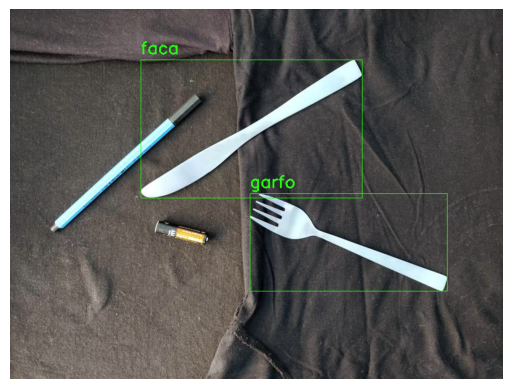

049.JPEG


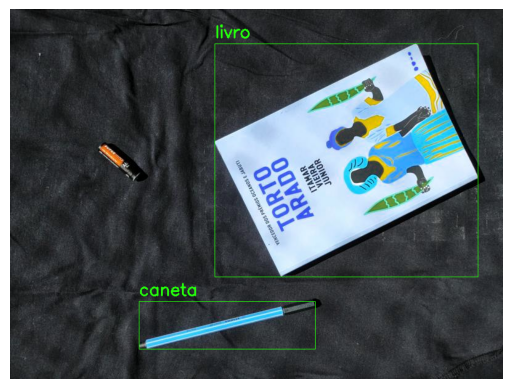

038.JPEG


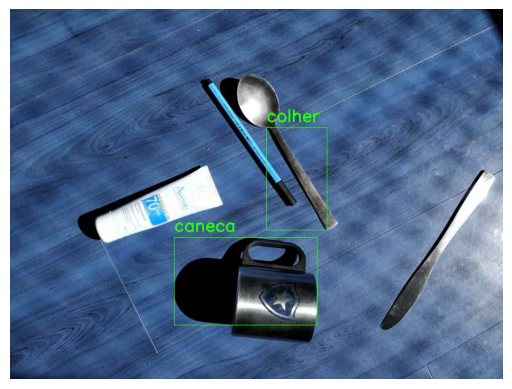

049.JPEG


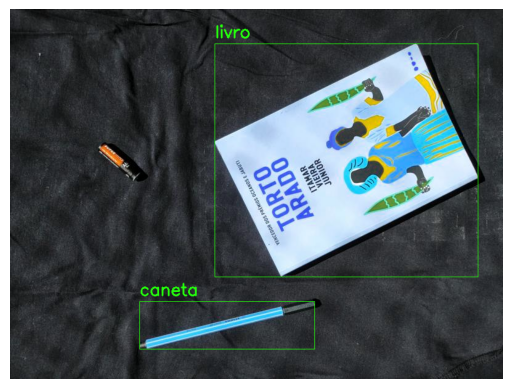

035.JPEG


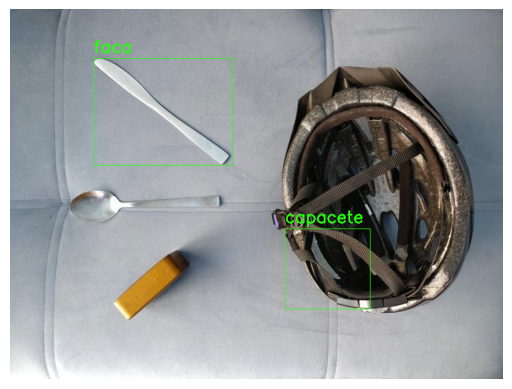

049.JPEG


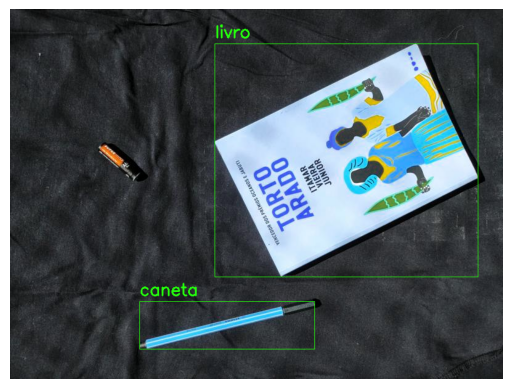

In [40]:

# Função principal para processar as amostras de imagens

def process_images(input_dir_gray, input_dir_color, smoothing_method='gaussian', edge_method='canny'):
    
    for root, dirs, files in os.walk(input_dir_gray):

        for file in files:

            if file in sample_imgs_list:
            #file.endswith('.jpeg') or file.endswith('.JPEG'):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_color_path = os.path.join(input_dir_color, file)
                img_color = cv2.imread(img_color_path, cv2.IMREAD_COLOR)


                if img is not None:
                    print(file.upper())

                    # Aplicar a suavização
                    img_smoothed = apply_smoothing(img, smoothing_method)
                    n = int(df_unique.loc[df['img'] == file.upper()]['n_objetos'].item()) #
                    img_info = df_unique_obj.loc[df['img'] == file.upper()]
                    
                    
                    # Aplicar a detecção de bordas
                    img_edges = edge_detection(img_smoothed, edge_method)

                    # Encontrar contornos
                    contours, hierarchy = cv2.findContours(img_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                    # Filtrar contornos próximos das bordas
                    contours = filter_contours_near_edges(contours, img.shape)

                    label_img = label(img_smoothed, connectivity=2)
                    props = regionprops(label_img)

                    # Calcular a área dos contornos
                    areas = []
                    for c in contours:
                        areas.append(cv2.contourArea(c))


                    areas_sorted = sorted(areas, reverse=True)

                    major_contours = []


                    for c in contours:
                        i = 1
                        if len(areas_sorted) >= n:
                            if (cv2.contourArea(c)) > float(areas_sorted[n]):
                                major_contours.append(c)
                                try:
                                    object = img_info.loc[df['n_contorno'] == len(major_contours)-1]['Objeto'].item()
                                
                                    if i == 1:
                                        
                                        img_rec = draw_rectangle(img_color, c, object)
                                        i +=1
                                    else:
                                        img_rec = draw_rectangle(img_rec, c, object)
                                except:
                                    pass
                        else:
                            if (cv2.contourArea(c)) > len(areas_sorted):
                                major_contours.append(c)
                                try:
                                    object = img_info.loc[df['n_contorno'] == len(major_contours)-1]['Objeto'].item()
                                
                                    if i == 1:
                                        
                                        img_rec = draw_rectangle(img_color, c, object)
                                        i +=1
                                    else:
                                        img_rec = draw_rectangle(img_rec, c, object)
                                except:
                                    pass

                    

                        
                    # Desenhar os contornos maiores na imagem original
                    plt.imshow(img_rec)
                    plt.axis('off')
                    plt.show()


caminho_original_gray = rf'..\data_EP3\selectedData\origin'
caminho_original_rgb = rf'..\data_resized'


# Processar e segmentar as imagens nos datasets suavizados para os métodos de detecção de bordas

process_images(caminho_original_gray, caminho_original_rgb, 'gaussian', 'canny')
